# Skin Disease classification using CNN Algorithm

# Import Libraries

In [2]:
import numpy as np
from tensorflow.keras.optimizers import Adam
from keras.layers import Activation, Dropout, Convolution2D, GlobalAveragePooling2D
from keras.models import Sequential
import tensorflow as tf
import os

In [2]:
IMG_SAVE_PATH = r'/kaggle/input/skin-disease-classification-image-dataset/Split_smol/train' 

In [3]:
Str_to_Int = {
    'Actinic keratosis': 0,
    'Atopic Dermatitis': 1,
    'Benign keratosis': 2,
    'Dermatofibroma': 3,
    'Melanocytic nevus': 4,
    'Melanoma':5,
    'Squamous cell carcinoma': 6,
    'Tinea Ringworm Candidiasis':7,
    'Vascular lesion': 8
}

NUM_CLASSES = 9


def str_to_Int_mapper(val):
    return Str_to_Int[val]

# Data Preprocessing


In [4]:
import PIL
import cv2 

dataset = []
for directory in os.listdir(IMG_SAVE_PATH):
    path = os.path.join(IMG_SAVE_PATH, directory)
    for image in os.listdir(path):
        new_path = os.path.join(path, image)
        try:
            imgpath=PIL.Image.open(new_path)
            #if imgpath.shape!=(240,240,3):
            imgpath=imgpath.convert('RGB')
            img = np.asarray(imgpath)
            img = cv2.resize(img, (240,240))
            img=img/255.
            dataset.append([img, directory]) 
        except FileNotFoundError:
            print('Image file not found. Skipping...')

In [5]:
data, labels = zip(*dataset)
temp = list(map(str_to_Int_mapper, labels))

In [6]:
len(data)

697

In [7]:
#data[0]

In [8]:
import keras
labels = keras.utils.to_categorical(temp)

In [9]:
count=0
for i in data:
    if i.shape!=(240, 240, 3):
        count=count+1
print(count)      

0


# CNN

In [10]:
def cnn():
    model=Sequential()

    model.add(Conv2D(8, kernel_size=(3,3), activation='relu', input_shape=(240,240,3)))
    model.add(Conv2D(16, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(9, activation='softmax'))
    
    return model

In [11]:
def split_data(X, y, train_size=0.7, val_size=0.15):
    total_size = len(X)
    
    train_end = int(train_size * total_size)
    val_end = train_end + int(val_size * total_size)
    
    X_train = X[:train_end]
    y_train = y[:train_end]
    
    X_val = X[train_end:val_end]
    y_val = y[train_end:val_end]
    
    X_test = X[val_end:]
    y_test = y[val_end:]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = split_data(np.array(data), np.array(labels))

In [12]:
import optuna
from keras.layers import Dense , Dropout , Conv2D , MaxPooling2D, Flatten

def objective(trial):
    model = Sequential()
    
    kernel_size = trial.suggest_int('kernel_size', 3, 10)    
    
    model.add(Conv2D(trial.suggest_int('conv1_units', 4, 32), kernel_size=(kernel_size, kernel_size+1), activation='relu', input_shape=(240, 240, 3)))
    model.add(Conv2D(trial.suggest_int('conv2_units', 4, 32), kernel_size=(kernel_size, kernel_size+1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(trial.suggest_uniform('dropout1', 0.0, 0.5)))
              
    model.add(Conv2D(trial.suggest_int('conv3_units', 4, 32), kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(trial.suggest_int('conv4_units', 4, 32), kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(trial.suggest_uniform('dropout2', 0.0, 0.5)))
              
    model.add(Flatten())
    model.add(Dense(trial.suggest_int('dense_units', 32, 128), activation='relu'))
    model.add(Dropout(trial.suggest_uniform('dropout3', 0.0, 0.5)))
    model.add(Dense(9, activation='softmax'))
    
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 0.15)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=64)
    
    return history.history['val_accuracy'][-1]

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=2)

best_params = study.best_params

[I 2023-11-03 03:48:06,862] A new study created in memory with name: no-name-a100fcef-c5d3-40e2-af30-4b09361b709b
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if sys.path[0] == "":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


Epoch 1/10
4/8 [==============>...............] - ETA: 24s - loss: 3209.0168 - accuracy: 0.0898

[W 2023-11-03 03:48:39,603] Trial 0 failed with parameters: {'kernel_size': 6, 'conv1_units': 11, 'conv2_units': 26, 'dropout1': 0.4281304267461045, 'conv3_units': 22, 'conv4_units': 14, 'dropout2': 0.1939982589454024, 'dense_units': 40, 'dropout3': 0.049612179502189324, 'learning_rate': 0.05100375938903611} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_27/1643999322.py", line 29, in objective
    history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=64)
  File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1650, in fit
    tmp_logs = self.train_function(iterator)
  File "/opt/conda/lib/python3.

KeyboardInterrupt: 

In [61]:
def train_and_record_accuracy(model, train_images, train_labels, test_images, test_labels, num_epochs):
    history = {"train_accuracy": [], "val_accuracy": []}
    for epoch in range(num_epochs):
        model.fit(train_images, train_labels, epochs=1, validation_data=(test_images, test_labels), batch_size=64)
        train_accuracy = model.evaluate(train_images, train_labels, verbose=0)[1]
        val_accuracy = model.evaluate(test_images, test_labels, verbose=0)[1]
        history["train_accuracy"].append(train_accuracy)
        history["val_accuracy"].append(val_accuracy)
        print(f"Epoch {epoch + 1}: Train Accuracy = {train_accuracy:.4f}, Validation Accuracy = {val_accuracy:.4f}")
    return history

In [65]:
best_model = Sequential()
best_model.add(Conv2D(best_params['conv1_units'], kernel_size=(3, 3), activation='relu', input_shape=(240, 240, 3)))
best_model.add(Conv2D(best_params['conv2_units'], kernel_size=(3, 3), activation='relu'))
best_model.add(MaxPooling2D(pool_size=(2, 2)))
best_model.add(Dropout(best_params['dropout1']))
best_model.add(Conv2D(best_params['conv3_units'], kernel_size=(3, 3), activation='relu'))
best_model.add(MaxPooling2D(pool_size=(2, 2)))
best_model.add(Conv2D(best_params['conv4_units'], kernel_size=(3, 3), activation='relu'))
best_model.add(MaxPooling2D(pool_size=(2, 2)))
best_model.add(Dropout(best_params['dropout2']))
best_model.add(Flatten())
best_model.add(Dense(best_params['dense_units'], activation='relu'))
best_model.add(Dropout(best_params['dropout3']))
best_model.add(Dense(9, activation='softmax'))

best_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

num_epochs = 2
history = train_and_record_accuracy(best_model, X_train, y_train, X_test, y_test, num_epochs)

train_accuracy_values = history["train_accuracy"]
val_accuracy_values = history["val_accuracy"]

8/8 [==============================] - 20s 2s/step - loss: 2.0862 - accuracy: 0.1910 - val_loss: 2.3249 - val_accuracy: 0.0000e+00
Epoch 1: Train Accuracy = 0.2074, Validation Accuracy = 0.0000
8/8 [==============================] - 19s 2s/step - loss: 1.8890 - accuracy: 0.2361 - val_loss: 2.4358 - val_accuracy: 0.0000e+00
Epoch 2: Train Accuracy = 0.2526, Validation Accuracy = 0.0000


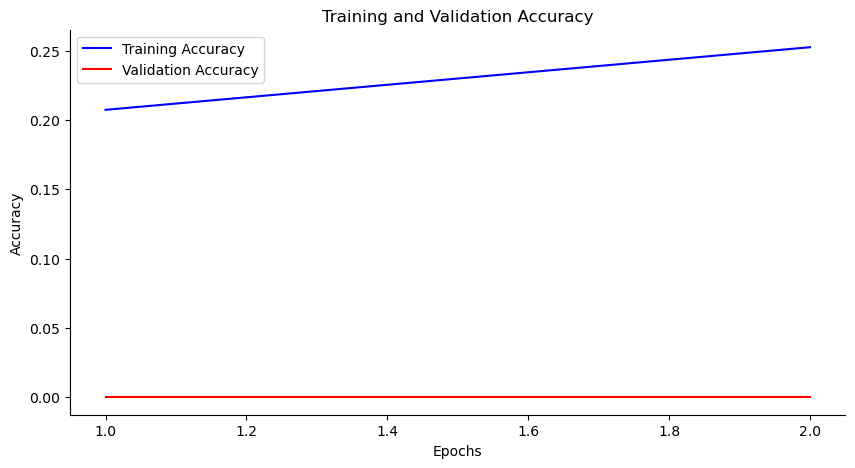

In [68]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_accuracy_values) + 1)

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracy_values, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy_values, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(False)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Display the plot
plt.show()